# Multi-Layer Perceptron (MLP) using MNIST

<a target="_blank" href="https://colab.research.google.com/github/denpalrius/AI-Machine-Learning-Practice/blob/main/tensorflow/basic_model.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt
import numpy as np

Define epochs, batch size for gradient descent and device(gpu or cpu) to use

In [2]:
BATCH_SIZE = 64
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data preparation and exploration

Create the transformer to be used to pre-process the dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Acquire the training, validation and test data, using MNIST

In [4]:
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               download=True,
                               transform=transform)

valid_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 16651685.24it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 499559.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4483164.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 4431386.08it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Split the training data into train and validation set

In [5]:
# Get the number of samples in the dataset
n_samples = train_dataset.data.shape[0]

# Define percentage of data to use for validation
validation_fraction = 0.1

In [6]:
validation_count = int(validation_fraction * n_samples)
train_indices = torch.arange(0, n_samples - validation_count)
valid_indices = torch.arange(n_samples - validation_count, n_samples)

Configure random samplers

In [7]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

Set up data loaders for training validation, and testing

In [8]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          sampler=train_sampler)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=valid_sampler)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

Checking the data dimensions before feeding to the newural network

In [9]:
for images, labels in train_loader:
  print('Image batch dimensions:', images.shape)
  print('Image label dimensions:', labels.shape)
  break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


Display a grid of sample images

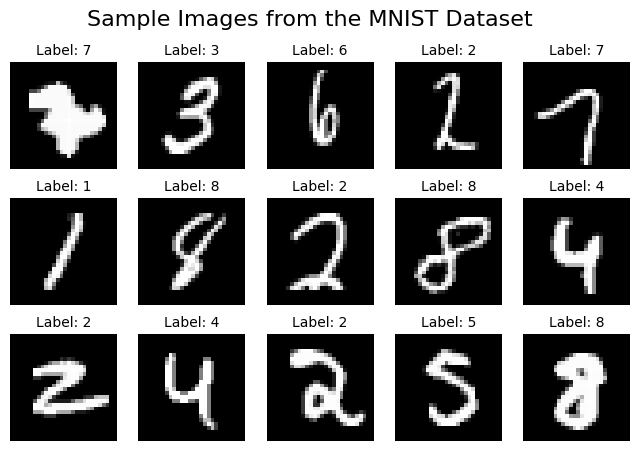

In [11]:
image_count = 15

plt.figure(figsize=(8, 5))
plt.suptitle('Sample Images from the MNIST Dataset', fontsize=16)

for i, (images, label) in enumerate(train_loader):
  for j in range(image_count):
    plt.subplot(3, 5, j + 1)
    plt.imshow(images[j].squeeze(), cmap='gray')
    plt.title(f"Label: {label[j].item()}", fontsize=10)
    plt.axis('off')
  break
plt.show()

# Neural network architecture design

Define an MLP model with two hidden layers and dropout regularization

In [12]:
class MLP(nn.Module):
    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super().__init__()

        self.network = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden_1),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2),
            torch.nn.BatchNorm1d(num_hidden_2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            # output layer
            torch.nn.Linear(num_hidden_2, num_classes)
        )

    def forward(self, x):
        logits = self.network(x)
        return logits

Initialize Model, Loss Function, Optimizer, and Learning Rate Scheduler

In [13]:
model = MLP(num_features=28*28,
            num_hidden_1=128,
            num_hidden_2=64,
            num_classes=10)

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.1,
                            momentum=0.9,
                            weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='min')

# Create optimizer using Adam
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create the scheduler with step decay
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Create the scheduler with exponential decay
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


# Training and Testing

Utility function to calculate the mode accuracy

In [14]:
def compute_accuracy(data_loader):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):
            features = features.to(DEVICE)
            targets = targets.float().to(DEVICE)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

Train and test the model

In [15]:
import time

start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()

    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # FORWARD AND BACK PROP
        logits = model(features)

        # loss = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        loss = criterion(logits, targets)
        optimizer.zero_grad()

        loss.backward()

        # UPDATE MODEL PARAMETERS
        optimizer.step()

        # LOGGING
        minibatch_loss_list.append(loss.item())
        logging_interval = 100

        if not batch_idx % logging_interval:
            print("Epoch: ", epoch+1, "/", NUM_EPOCHS, 
                  "| Batch ", batch_idx,
                  "/", len(train_loader), 
                  f'| Loss: {loss:.4f}')

    model.eval()

    with torch.no_grad():  # save memory during inference
        train_acc = compute_accuracy(train_loader)
        valid_acc = compute_accuracy(valid_loader)
        print("Epoch: ", epoch+1, "/", NUM_EPOCHS,
              f'| Train: {train_acc :.2f}% '
              f'| Validation: {valid_acc :.2f}%')

        train_acc_list.append(train_acc.item())
        valid_acc_list.append(valid_acc.item())

    elapsed = (time.time() - start_time) / 60
    print("Time elapsed: ", elapsed, " min")
    scheduler.step(minibatch_loss_list[-1])

    elapsed = (time.time() - start_time) / 60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(test_loader)
    print(f'Test accuracy {test_acc :.2f}%')

    print('=================\n')

Epoch:  1 / 20 | Batch  0 / 843 | Loss: 2.5543
Epoch:  1 / 20 | Batch  100 / 843 | Loss: 0.5837
Epoch:  1 / 20 | Batch  200 / 843 | Loss: 0.4686
Epoch:  1 / 20 | Batch  300 / 843 | Loss: 0.2799
Epoch:  1 / 20 | Batch  400 / 843 | Loss: 0.3236
Epoch:  1 / 20 | Batch  500 / 843 | Loss: 0.4845
Epoch:  1 / 20 | Batch  600 / 843 | Loss: 0.3181
Epoch:  1 / 20 | Batch  700 / 843 | Loss: 0.2870
Epoch:  1 / 20 | Batch  800 / 843 | Loss: 0.2534
Epoch:  1 / 20 | Train: 95.33% | Validation: 96.48%
Time elapsed:  0.49015893538792926  min
Total Training Time: 0.49 min
Test accuracy 95.30%

Epoch:  2 / 20 | Batch  0 / 843 | Loss: 0.3253
Epoch:  2 / 20 | Batch  100 / 843 | Loss: 0.4645
Epoch:  2 / 20 | Batch  200 / 843 | Loss: 0.2740
Epoch:  2 / 20 | Batch  300 / 843 | Loss: 0.1132
Epoch:  2 / 20 | Batch  400 / 843 | Loss: 0.3080
Epoch:  2 / 20 | Batch  500 / 843 | Loss: 0.2537
Epoch:  2 / 20 | Batch  600 / 843 | Loss: 0.3340
Epoch:  2 / 20 | Batch  700 / 843 | Loss: 0.5247
Epoch:  2 / 20 | Batch  800

Visualize the training progress

Text(0, 0.5, 'Loss')

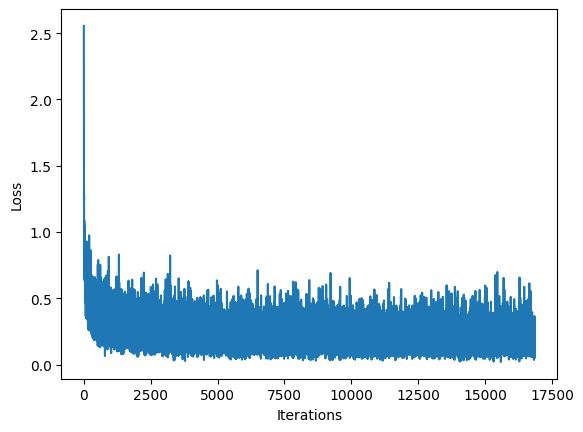

In [16]:
plt.plot(range(len(minibatch_loss_list)), minibatch_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')

Compare the training and validation accuracies over epochs

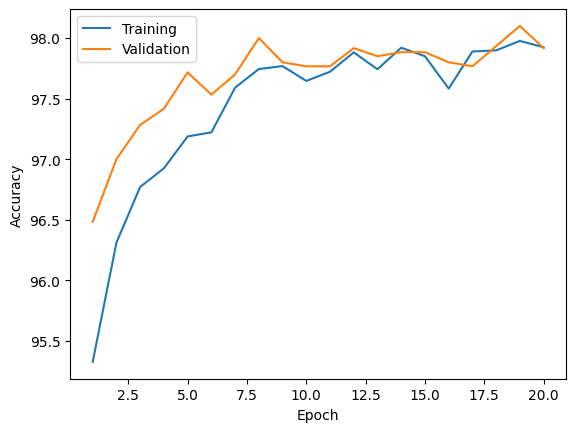

In [17]:
num_epochs = len(train_acc_list)
plt.plot(np.arange(1, num_epochs+1),
         train_acc_list, label='Training')
plt.plot(np.arange(1, num_epochs+1),
         valid_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()